In [110]:
library(tidyverse)
library(caret)
library(lattice)
library(dygraphs)
library(cowplot)
library(ggthemr)

ggthemr::ggthemr("fresh")
options(repr.plot.width=12, repr.plot.height=5)

Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”

_Note: All EDA done on training split only_

## What value do the zones add?

### For regression

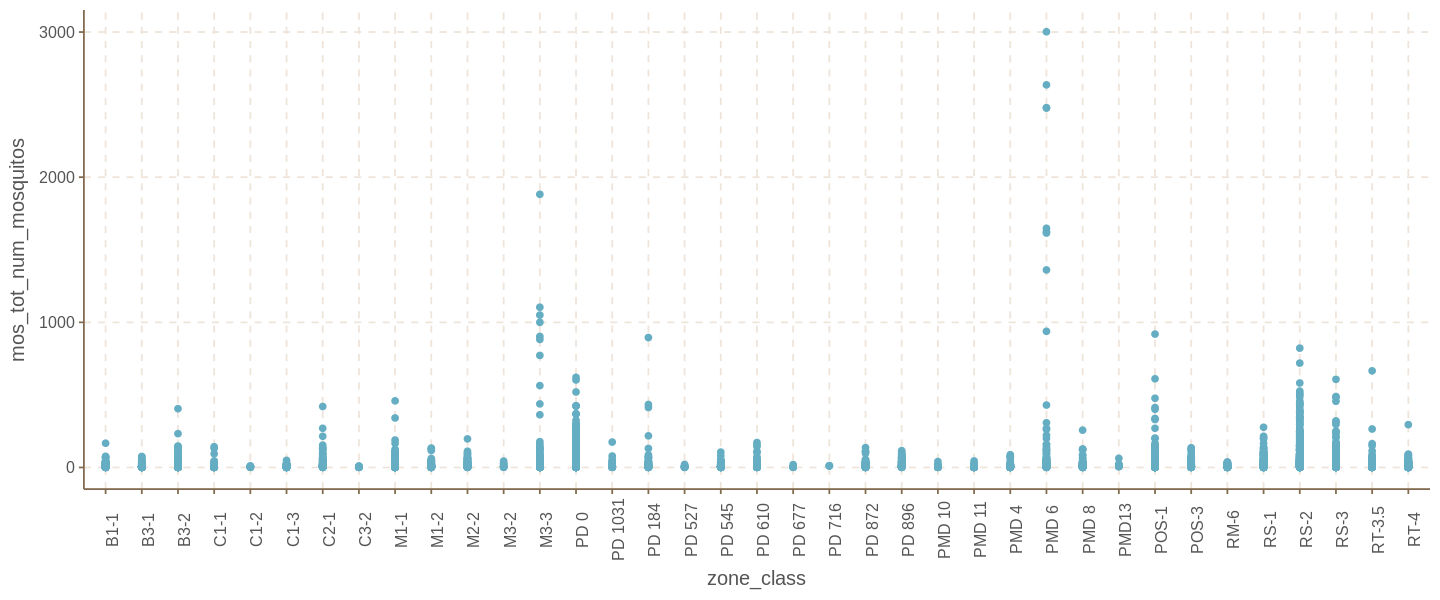

In [111]:
df_train %>% ggplot(aes(y=mos_tot_num_mosquitos,x=zone_class)) + geom_point() + 
    theme(axis.text.x = element_text(angle=90))

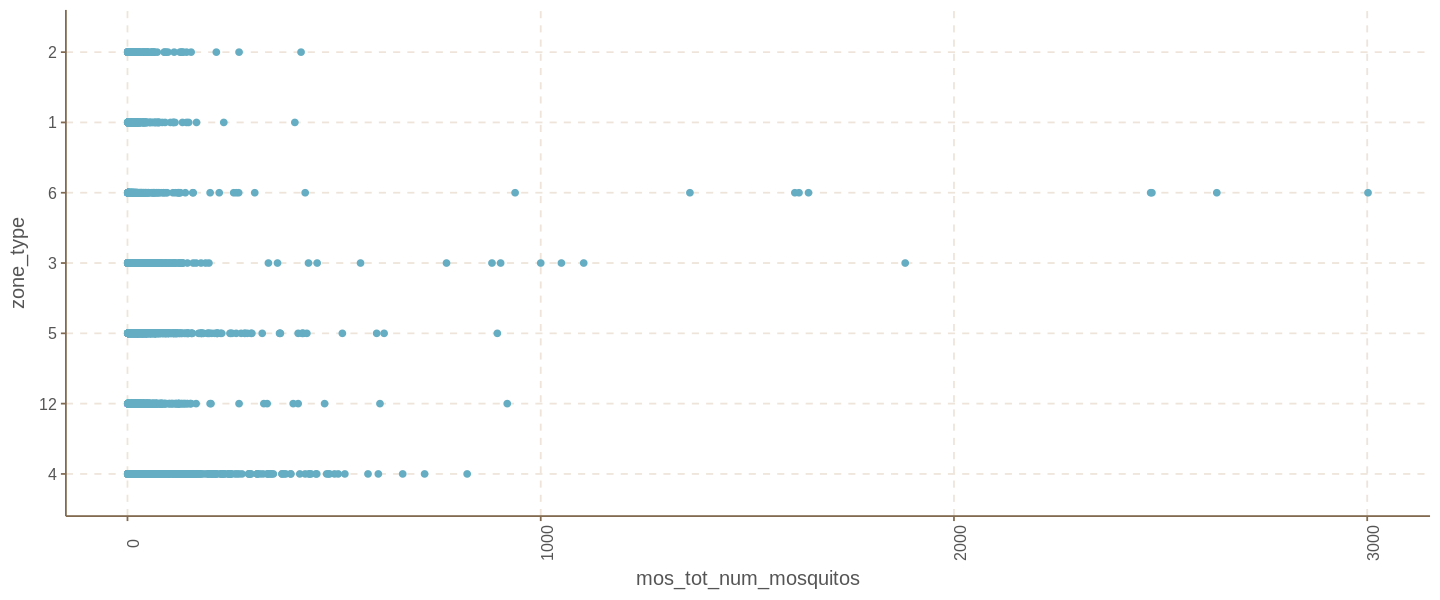

In [112]:
df_train %>% ggplot(aes(y=mos_tot_num_mosquitos,x=zone_type)) + geom_point() + 
    theme(axis.text.x = element_text(angle=90))+coord_flip()

## For classification

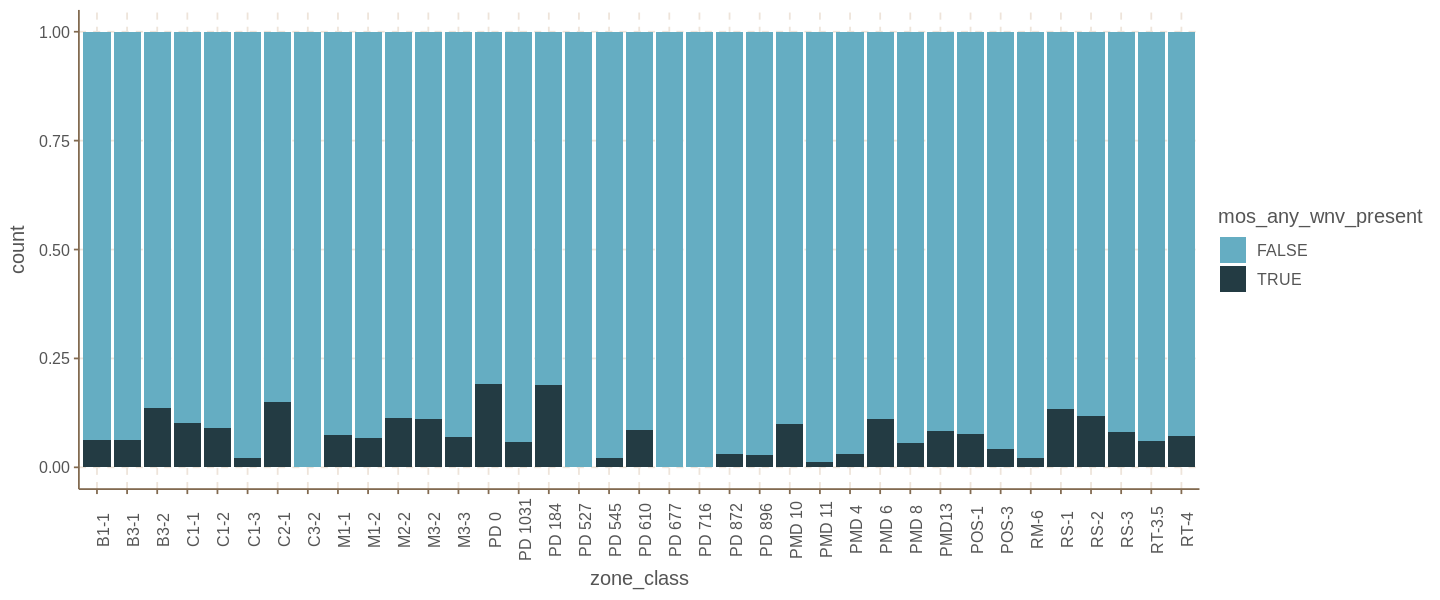

In [113]:
df_train %>% ggplot(aes(fill=mos_any_wnv_present,zone_class)) +
    geom_bar(position="fill")+theme(axis.text.x = element_text(angle=90))

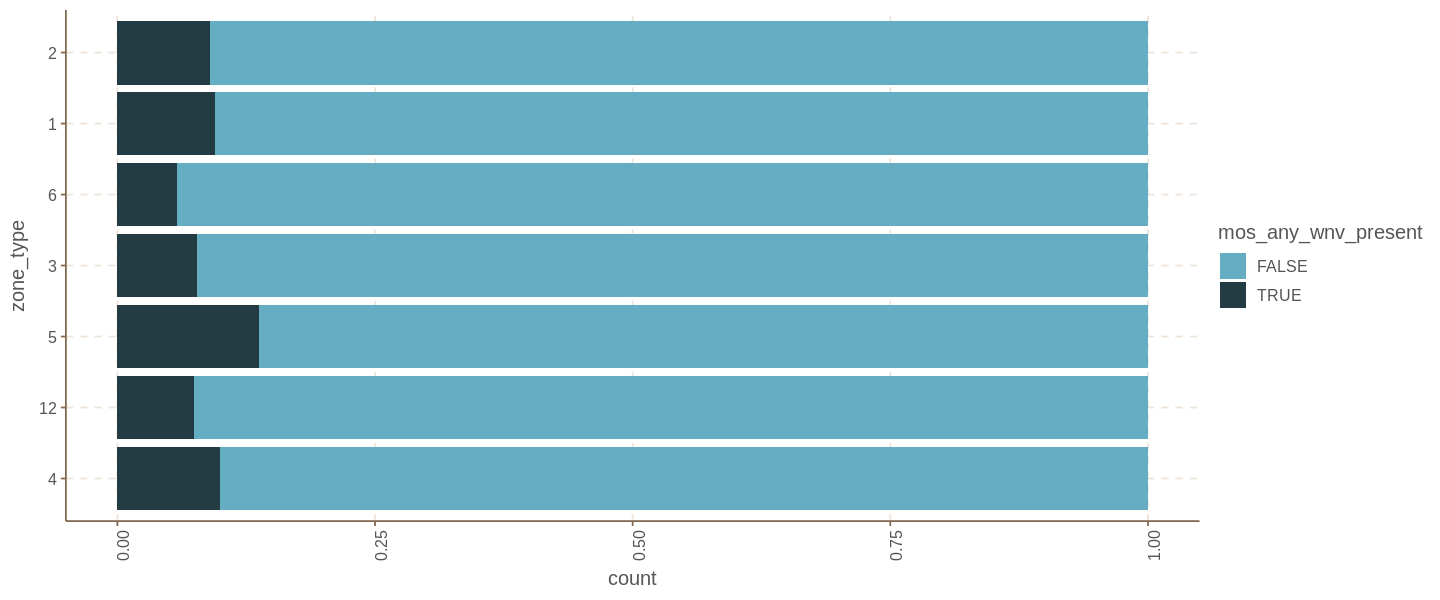

In [114]:
df_train %>% ggplot(aes(fill=mos_any_wnv_present,zone_type)) +
    geom_bar(position="fill")+theme(axis.text.x = element_text(angle=90))+coord_flip()

### Where are the different zones located?

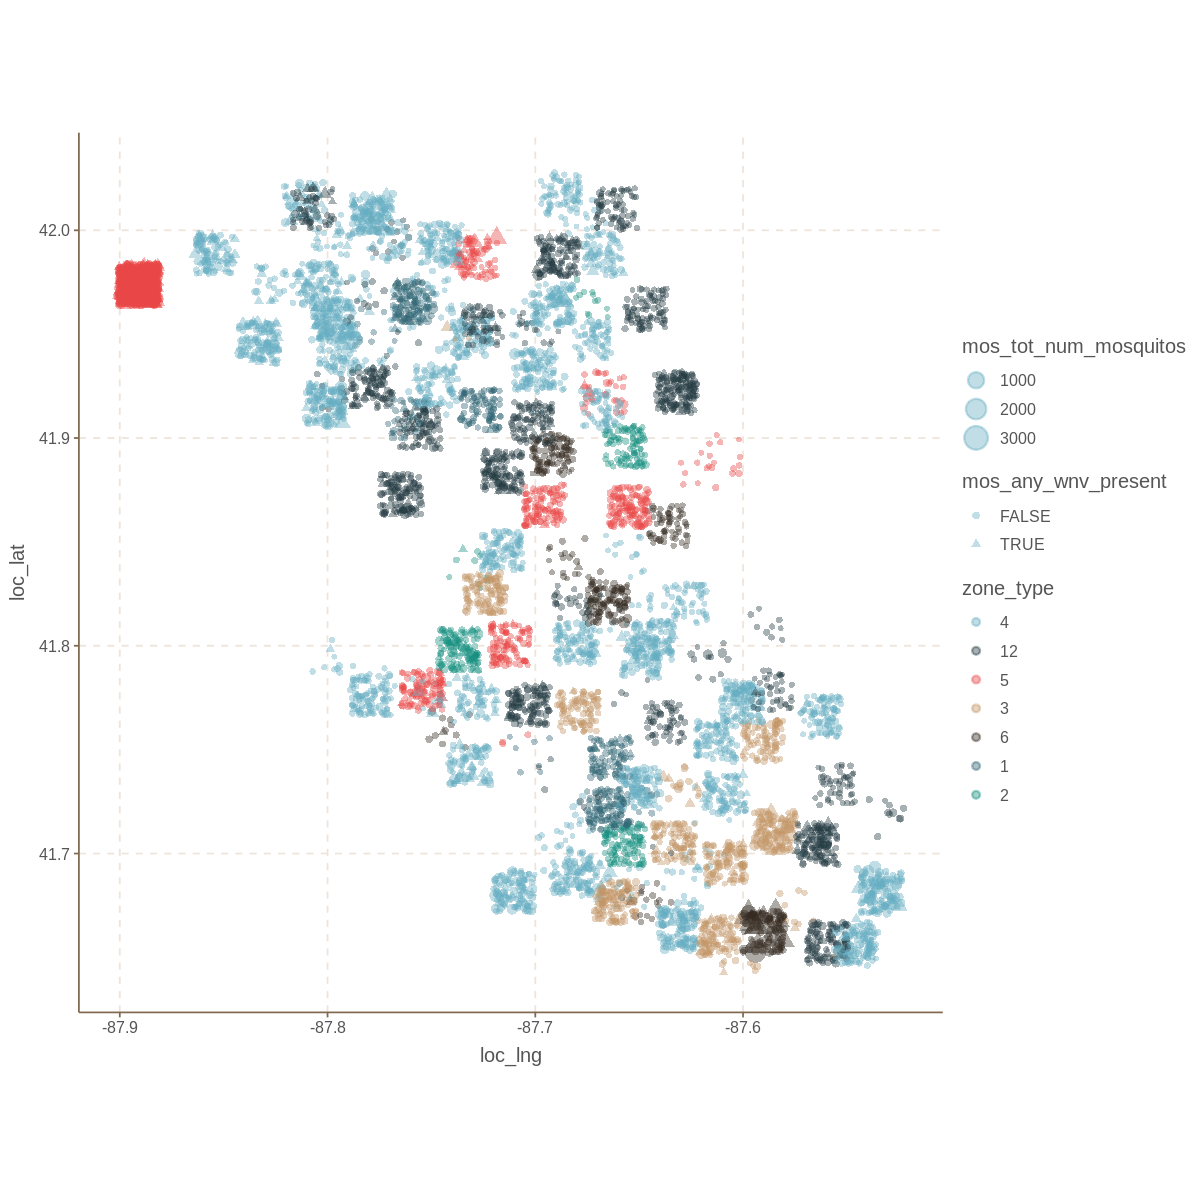

In [118]:
options(repr.plot.width=10, repr.plot.height=10)
df_train %>%
    ggplot(aes(loc_lng,loc_lat,color=zone_type,shape=mos_any_wnv_present,size=mos_tot_num_mosquitos))+
    geom_jitter(width = 0.01, height = 0.01, alpha = 0.4, stroke = 1)+
    coord_equal()
options(repr.plot.width=12, repr.plot.height=5)

What's going on with that dark red square on the top left?

And note the large sized black triangles at the bottom right too. Interesting.

# Do the trap variables offer anything?

In [85]:
df_train %>% select(starts_with("trap")) %>% head()

trap_trap_name,trap_satellite_ind,trap_trap_type
T002,FALSE,GRAVID
T007,FALSE,CDC
T015,FALSE,GRAVID
T045,FALSE,GRAVID
T046,FALSE,CDC
T048,FALSE,GRAVID


## For regression?

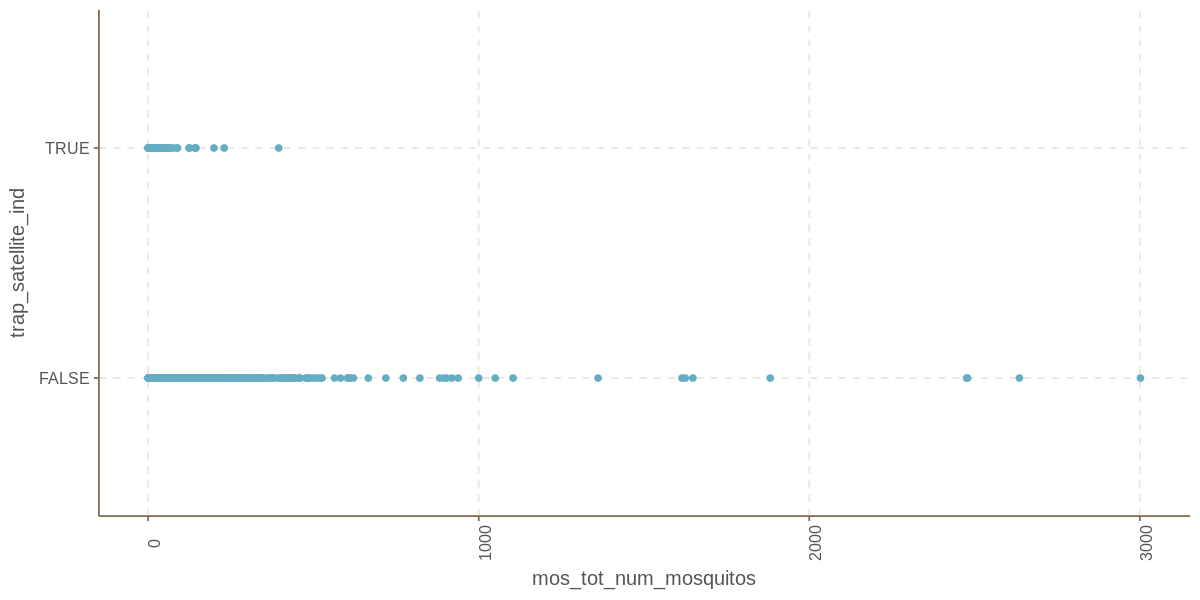

In [86]:
options(repr.plot.width=10, repr.plot.height=5)
df_train %>% ggplot(aes(y=mos_tot_num_mosquitos,x=trap_satellite_ind)) + geom_point() + 
    theme(axis.text.x = element_text(angle=90)) + coord_flip()

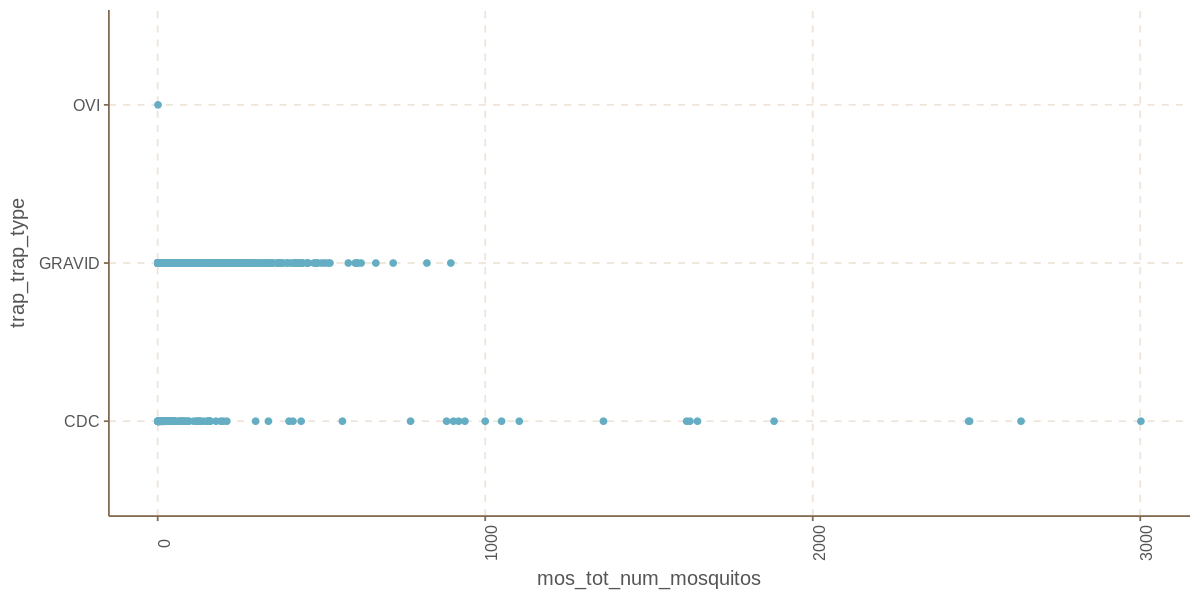

In [87]:
df_train %>% ggplot(aes(y=mos_tot_num_mosquitos,x=trap_trap_type)) + geom_point() + 
    theme(axis.text.x = element_text(angle=90)) + coord_flip()

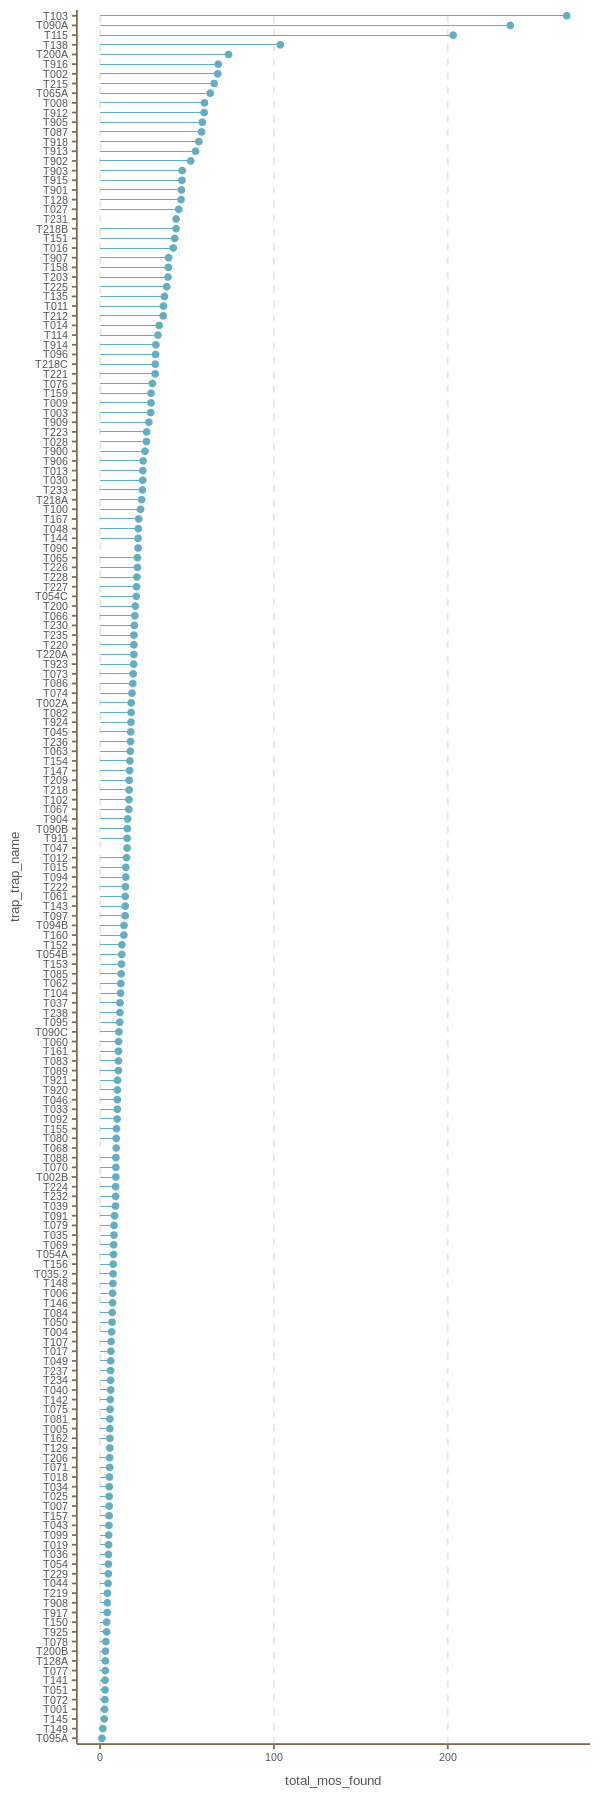

In [88]:
options(repr.plot.width=5, repr.plot.height=15)
df_train %>% 
    select(mos_tot_num_mosquitos, trap_trap_name) %>%
    group_by(trap_trap_name) %>%
    summarize(total_mos_found = sum(mos_tot_num_mosquitos)/length(trap_trap_name)) %>%
    mutate(trap_trap_name = factor(trap_trap_name,levels = trap_trap_name[order(.$total_mos_found)])) %>%
    ggplot(aes(y=total_mos_found,x=trap_trap_name)) +
    geom_point()+geom_col(width = .1)+theme(text = element_text(size=8))+
    coord_flip() + theme(panel.grid.major.y = element_blank())

## For classification?

Why is that one trap "T090A" 100% infected?

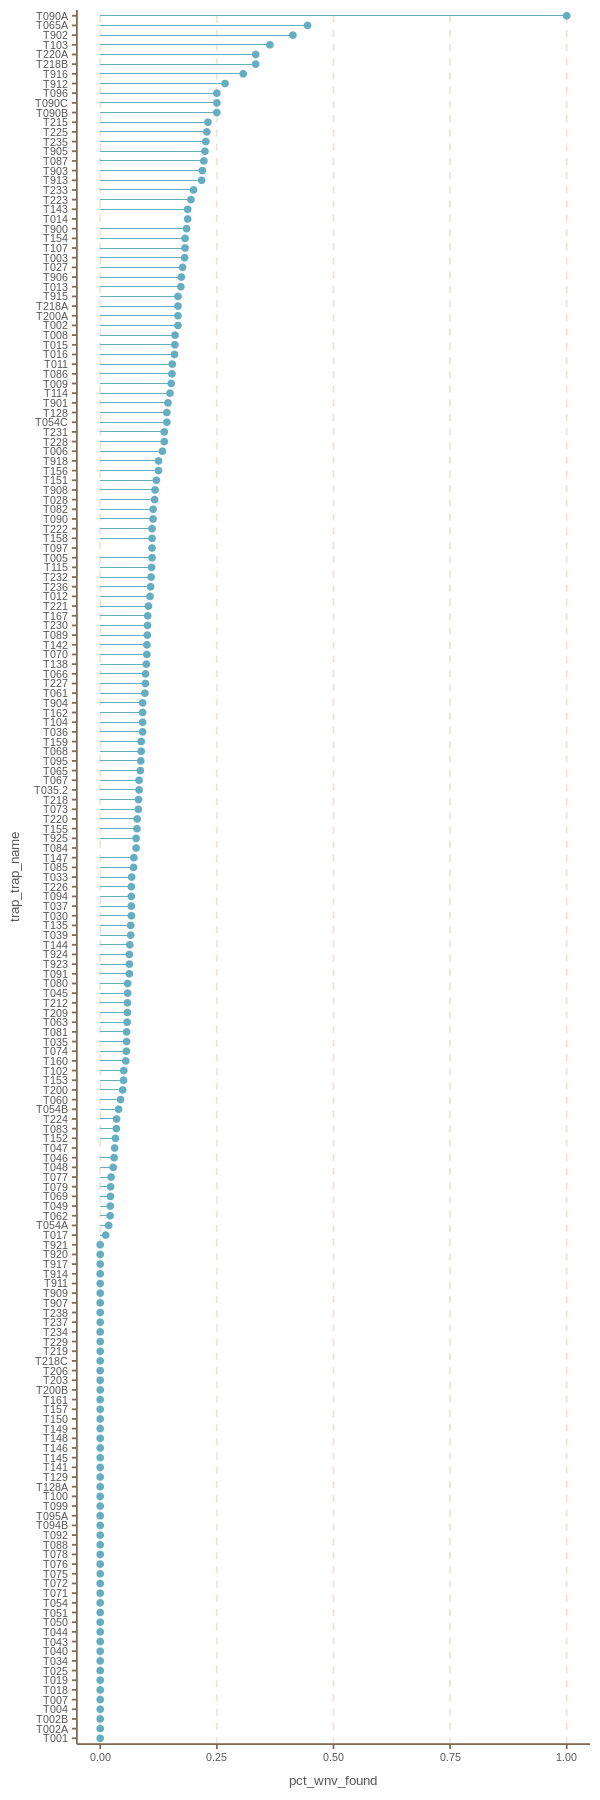

In [89]:
options(repr.plot.width=5, repr.plot.height=15)
df_train %>% 
    select(mos_any_wnv_present, trap_trap_name) %>%
    group_by(trap_trap_name) %>%
    summarize(pct_wnv_found = sum(mos_any_wnv_present)/length(trap_trap_name)) %>%
    mutate(trap_trap_name = factor(trap_trap_name,levels = trap_trap_name[order(.$pct_wnv_found)])) %>%
    ggplot(aes(y=pct_wnv_found,x=trap_trap_name)) +
    geom_point()+geom_col(width = .1)+theme(text = element_text(size=8))+
    coord_flip() + theme(panel.grid.major.y = element_blank())

The satellite variable adds no information

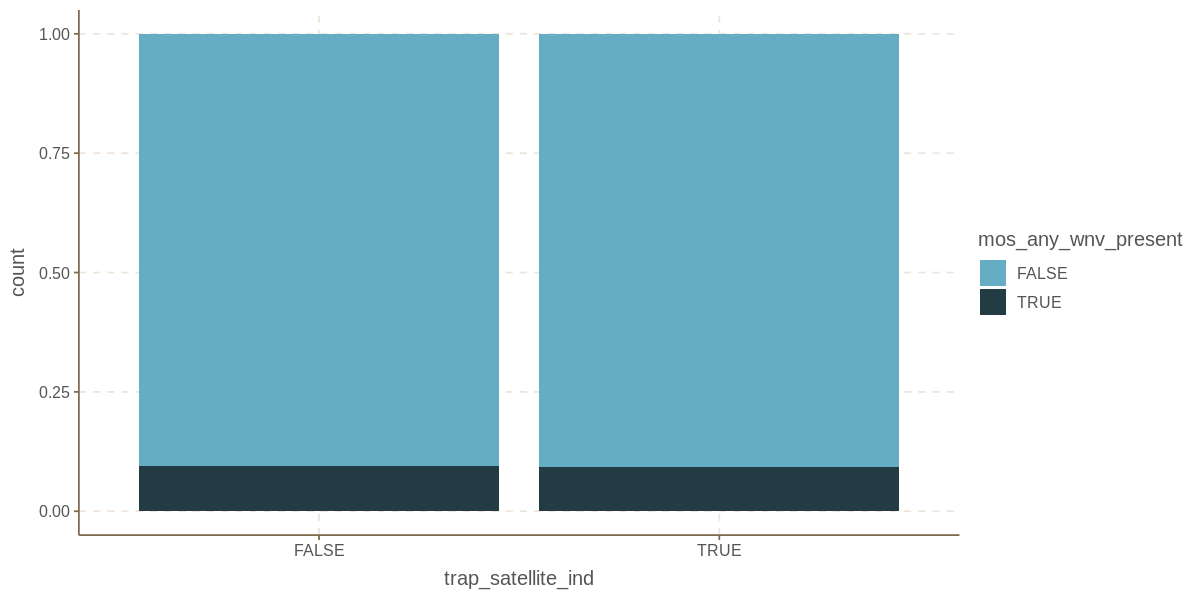

In [90]:
options(repr.plot.width=10, repr.plot.height=5)
df_train %>%
    ggplot(aes(fill=mos_any_wnv_present,trap_satellite_ind))+
    geom_bar(position = "fill")

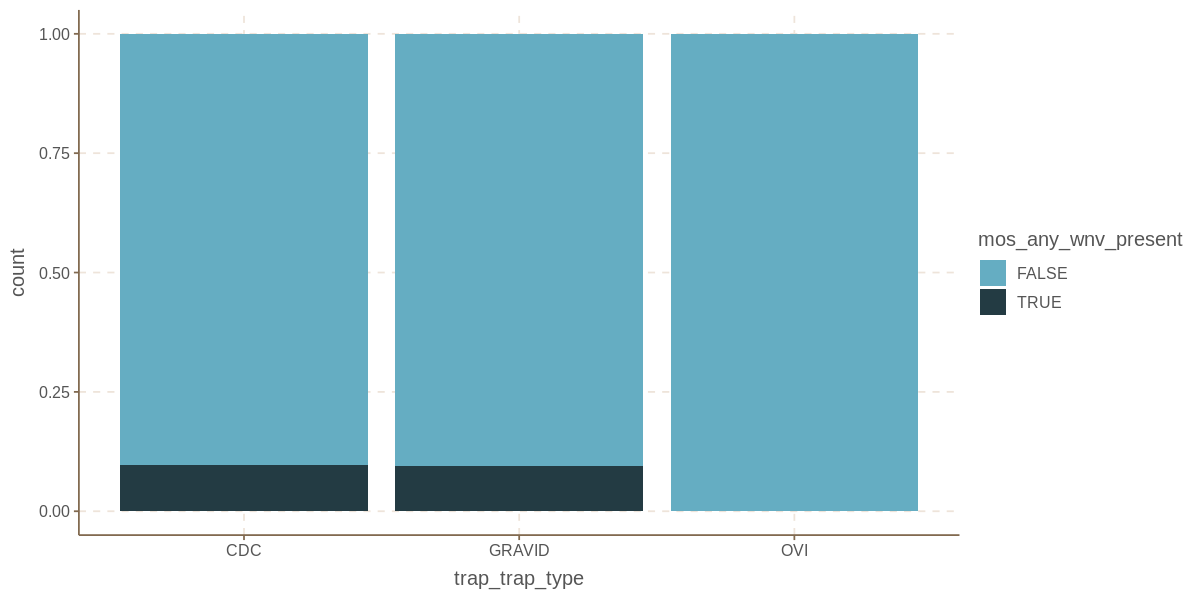

In [91]:
df_train %>%
    ggplot(aes(fill=mos_any_wnv_present,trap_trap_type))+
    geom_bar(position = "fill")

# What do the location variables offer?

In [92]:
df_loc = df_train %>% dplyr::select(starts_with("loc_"),
                                    "mos_any_wnv_present","mos_tot_num_mosquitos")

In [93]:
head(df_loc)

loc_lat,loc_lng,loc_lat_lng_src,loc_zipcode,loc_census_block_group_id,loc_census_tract_id,loc_community,mos_any_wnv_present,mos_tot_num_mosquitos
41.95630,-87.79752,CDPH,60634,170311701001,17031170100,DUNNING,FALSE,2
41.99549,-87.76961,CDPH,60646,170311201003,17031120100,FOREST GLEN,FALSE,1
41.97418,-87.82524,CDPH,60656,170311005005,17031100500,NORWOOD PARK,FALSE,5
41.92170,-87.66696,CDPH,60614,170318325001,17031832500,LINCOLN PARK,FALSE,2
41.89222,-87.69170,CDPH,60612,170318367002,17031836700,HUMBOLDT PARK,FALSE,1
41.86692,-87.65492,CDPH,60608,170312838001,17031283800,NEAR WEST SIDE,FALSE,3


## Lat Long Source

Lat Long source seems to have some predictive power

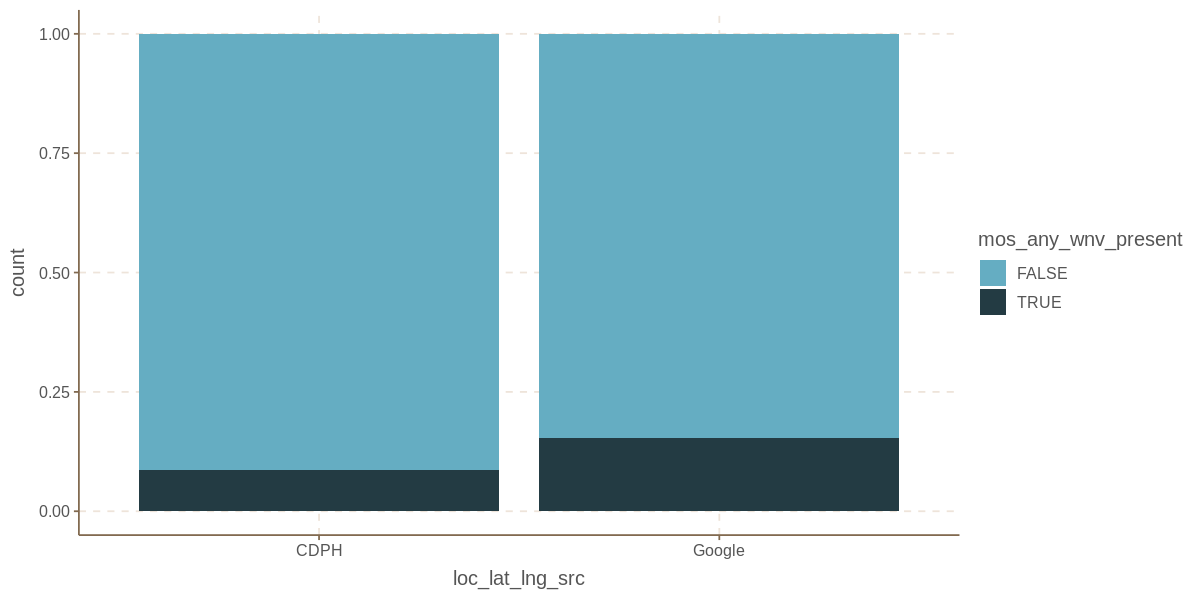

In [94]:
df_loc %>%
    ggplot(aes(fill=mos_any_wnv_present,loc_lat_lng_src))+
    geom_bar(position = "fill")

## Community

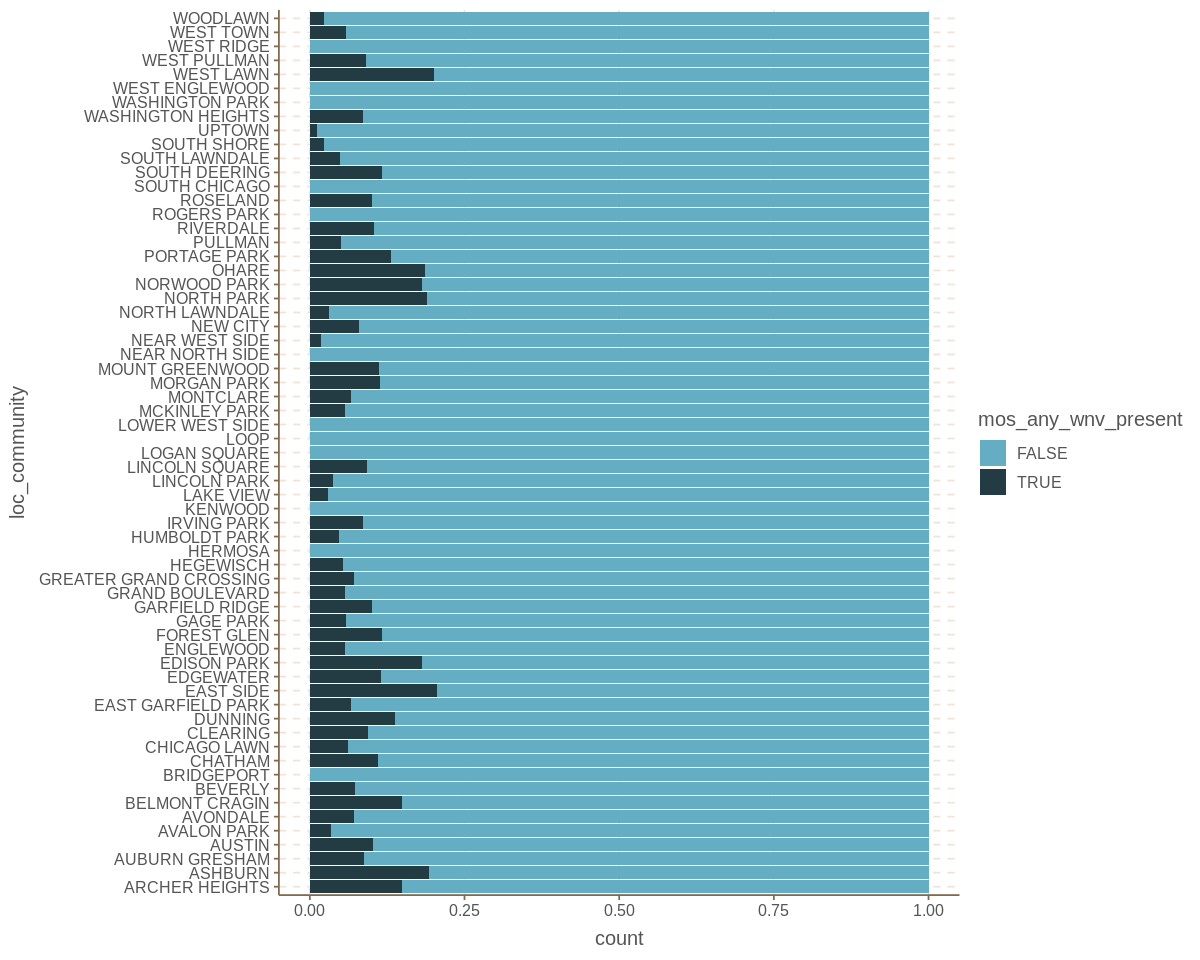

In [95]:
options(repr.plot.width=10, repr.plot.height=8)
df_loc %>%
    ggplot(aes(fill=mos_any_wnv_present,loc_community))+
    geom_bar(position = "fill") + coord_flip()

Same plot as before, but color coded by Community

In [96]:
options(repr.plot.width=10, repr.plot.height=10)
color_pal = sample(colors(distinct = T),70,replace = F)
cust_theme = define_palette(swatch = color_pal, gradient = c(head(color_pal,1),tail(color_pal,1)))

Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”

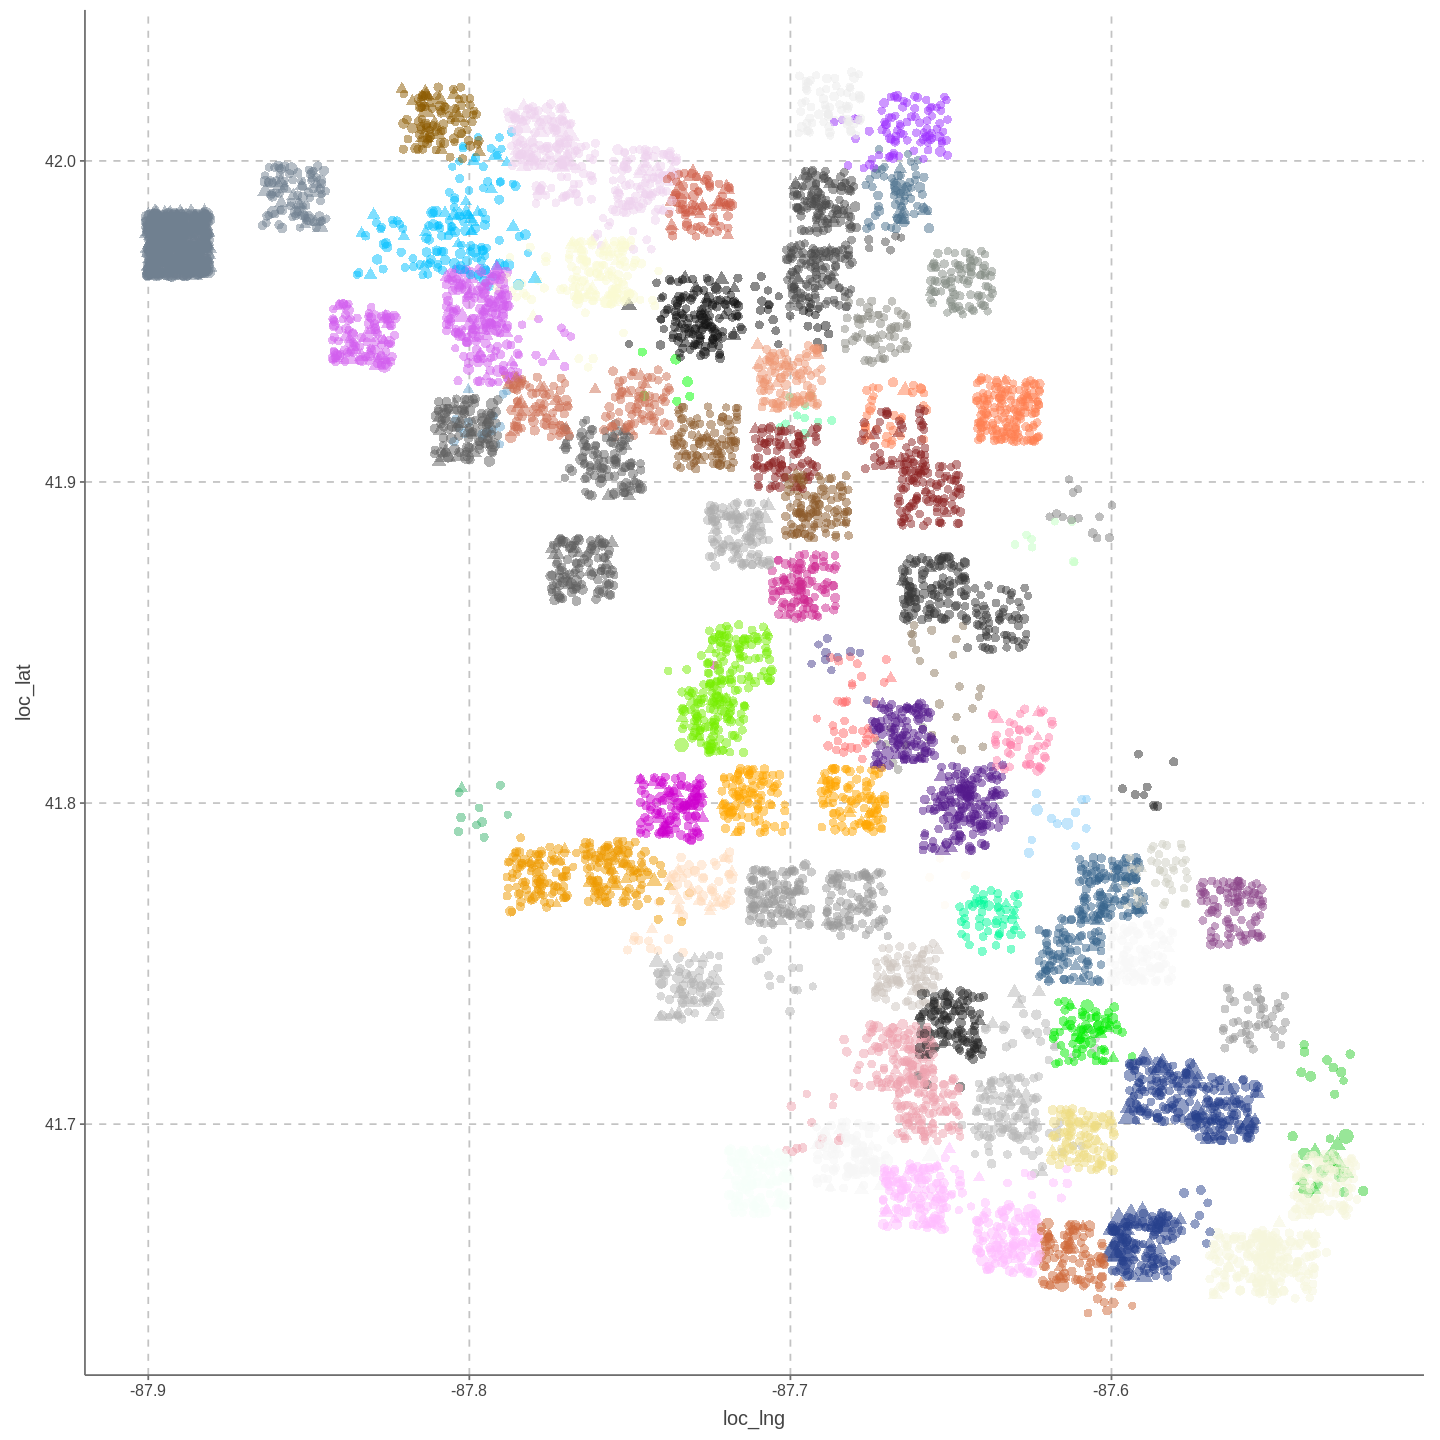

In [108]:
ggthemr(cust_theme)
options(repr.plot.width=12, repr.plot.height=12)
df_train %>%
    ggplot(aes(loc_lng,loc_lat,color=loc_community,shape=mos_any_wnv_present,size=mos_tot_num_mosquitos))+
    geom_jitter(width = 0.01, height = 0.01, alpha = 0.5, stroke=2)+
    coord_equal()+
    theme(legend.position = "none")

In [100]:
ggthemr("fresh")

Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”

## Block

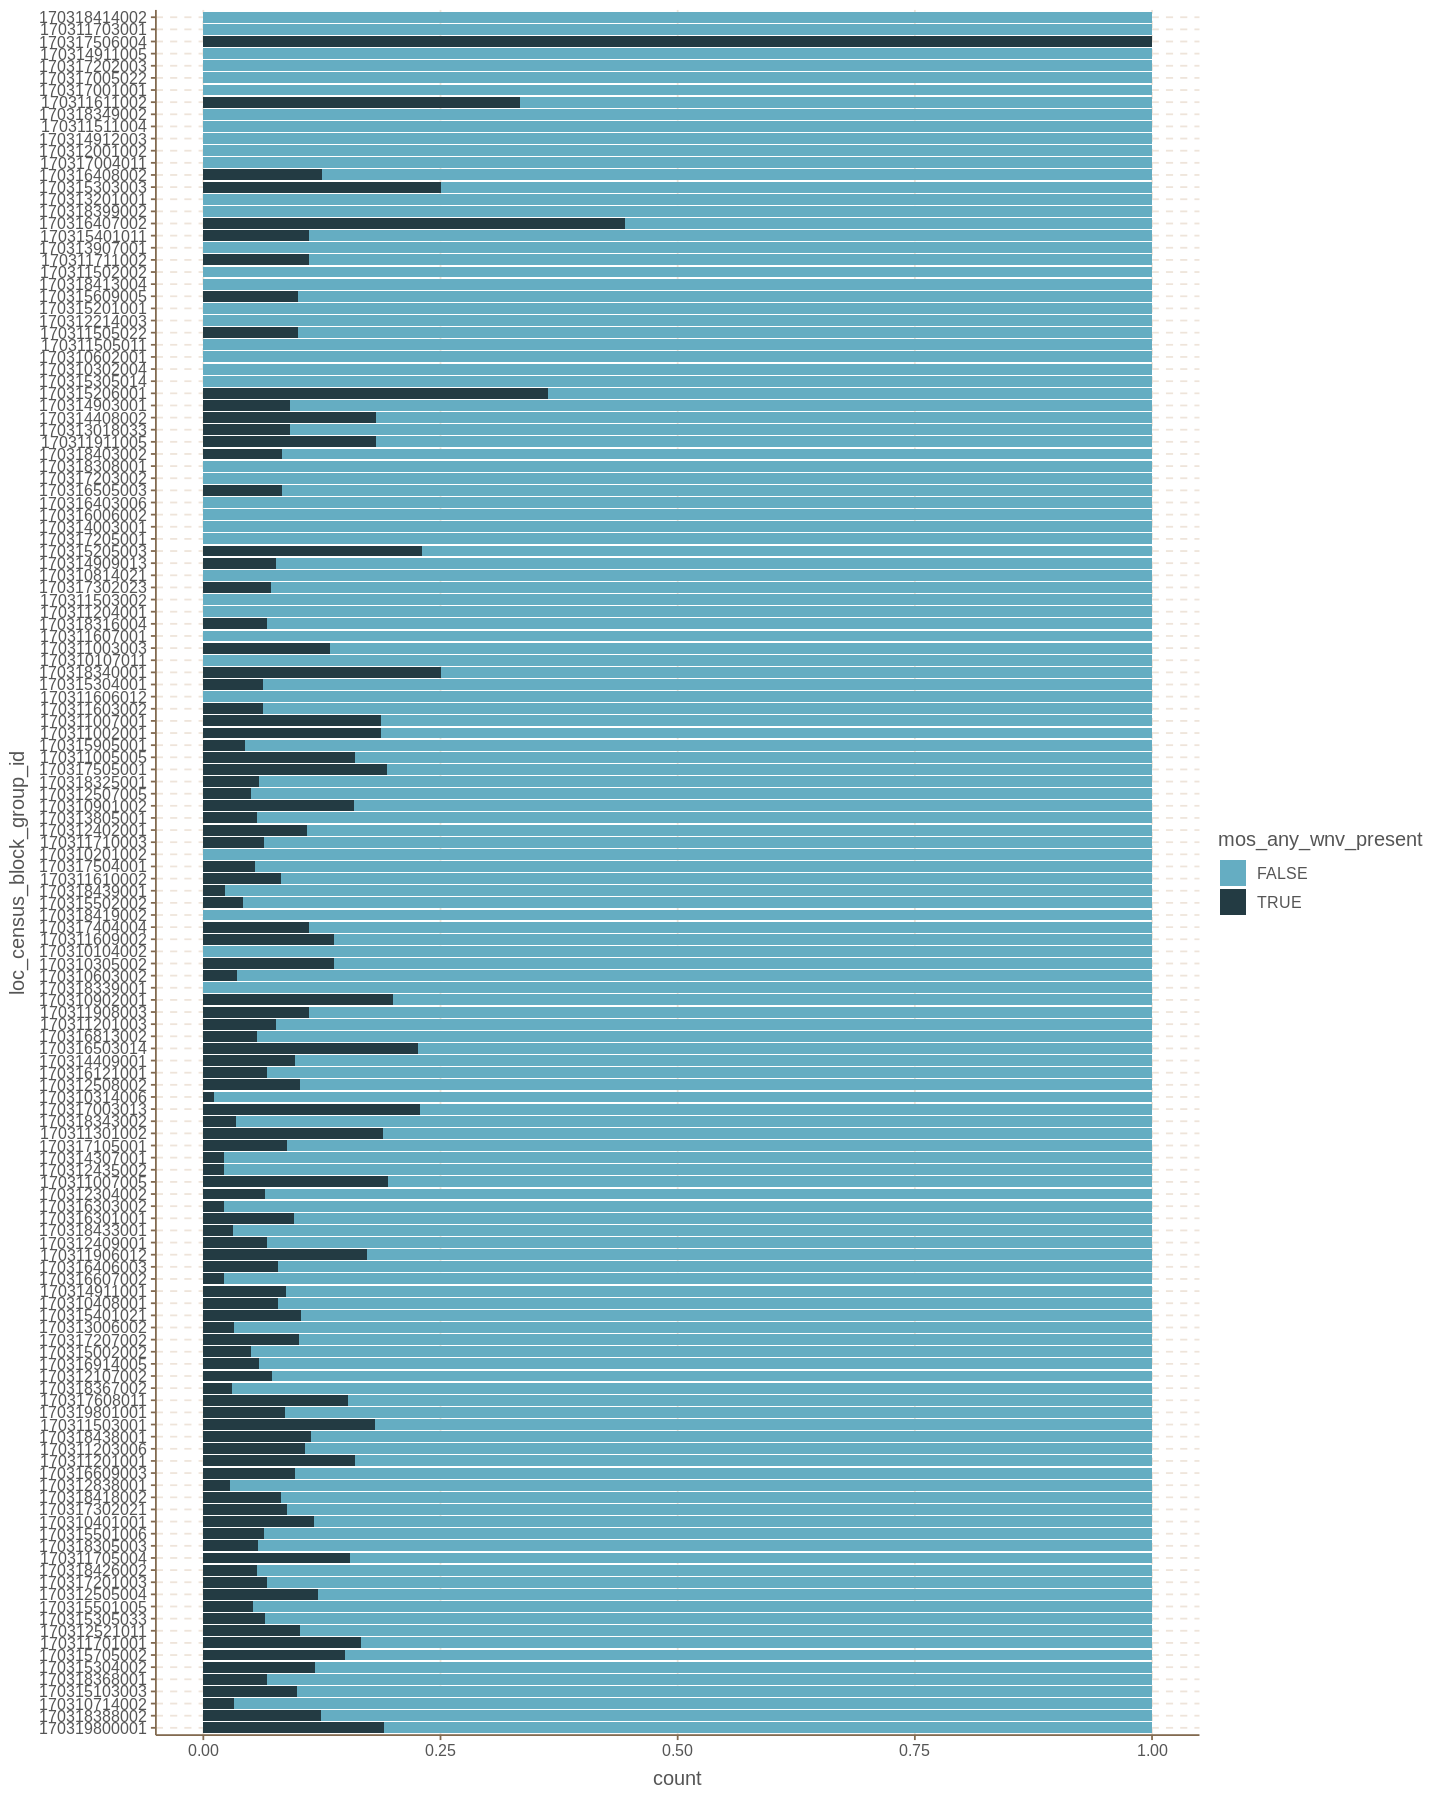

In [102]:
options(repr.plot.width=12, repr.plot.height=15)
df_loc %>%
    ggplot(aes(fill=mos_any_wnv_present,loc_census_block_group_id))+
    geom_bar(position = "fill") + coord_flip()

Zipcode certainly has predictive power. Some zipcodes are not affected at all.

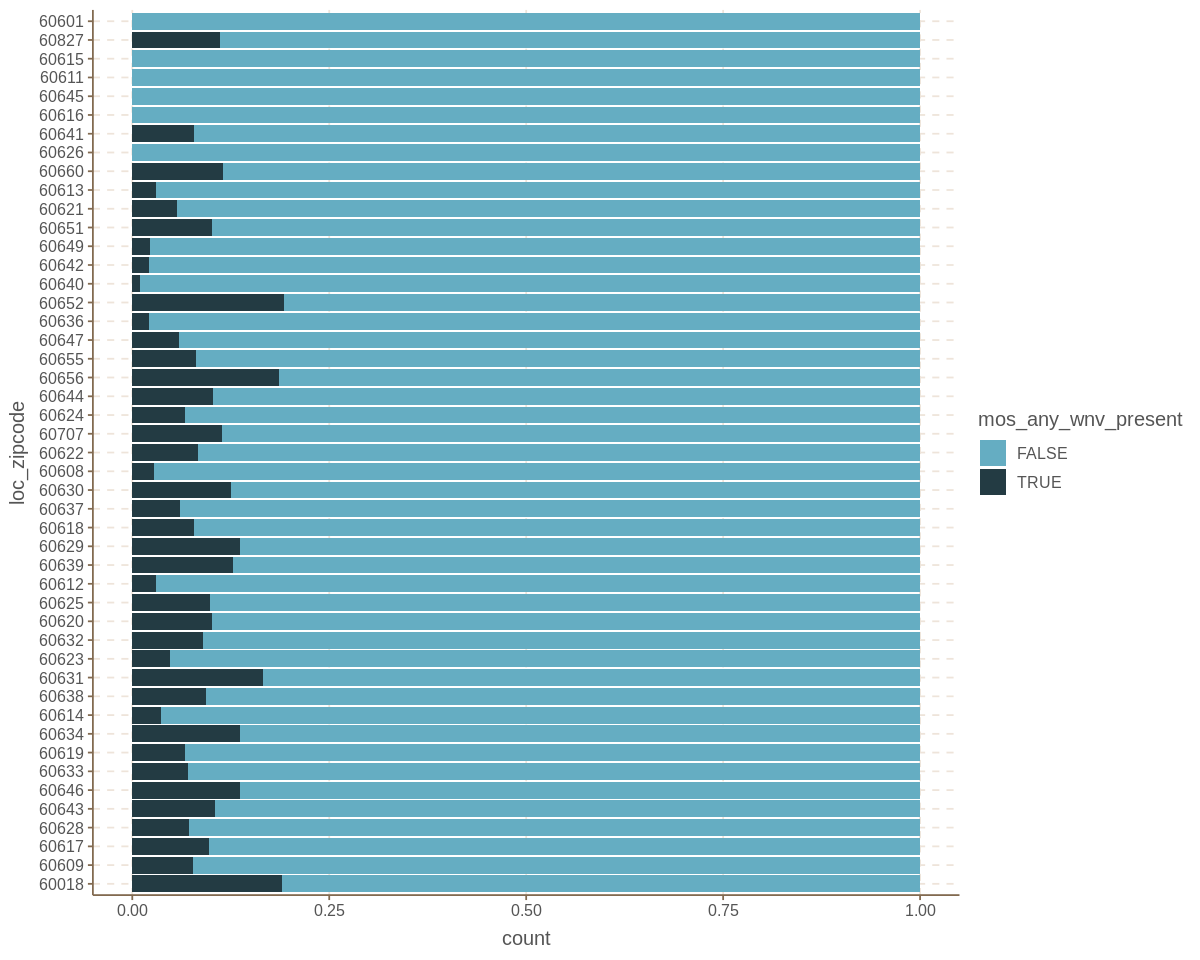

In [103]:
options(repr.plot.width=10, repr.plot.height=8)
df_loc %>%
    ggplot(aes(fill=mos_any_wnv_present,loc_zipcode))+
    geom_bar(position = "fill") + coord_flip()

How do the zipcodes with active WNV vary over time?

Warning message:
“Transformation introduced infinite values in discrete y-axis”Warning message in sqrt(x):
“NaNs produced”Warning message:
“Removed 3927 rows containing missing values (geom_point).”

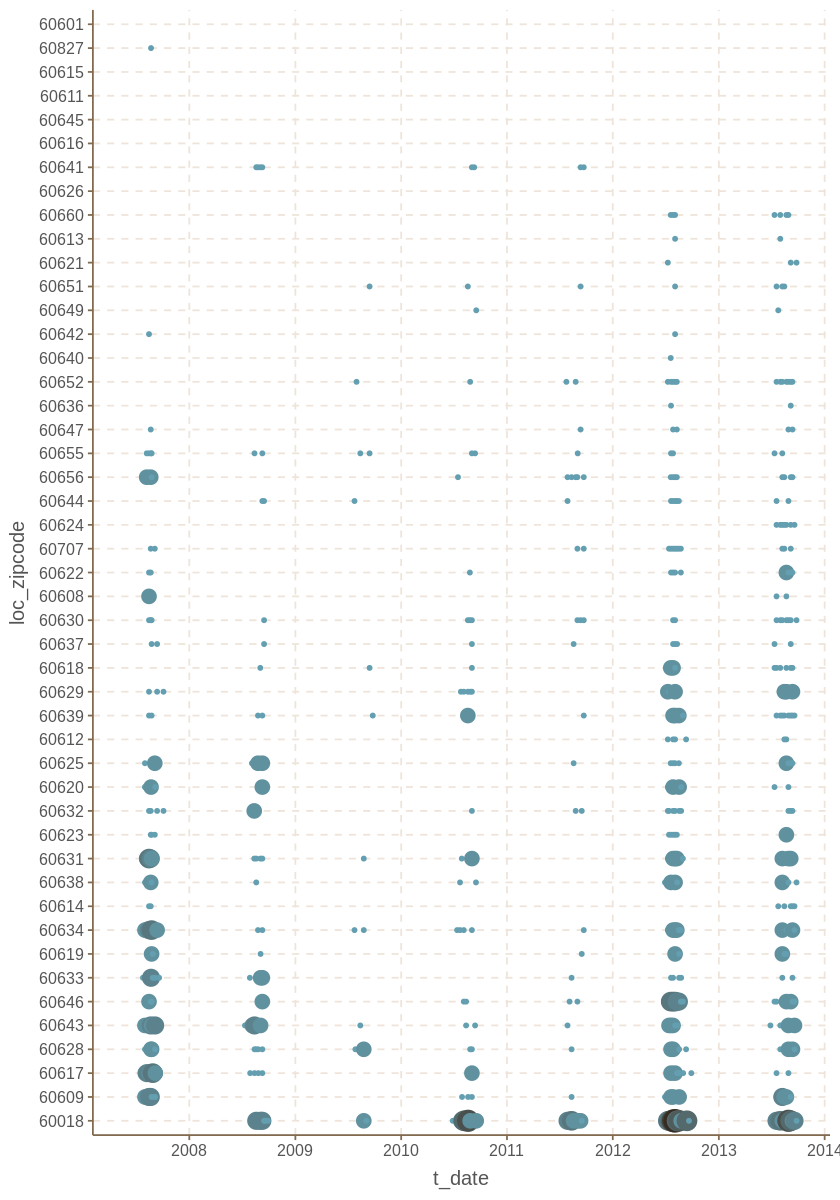

In [137]:
options(repr.plot.width=7, repr.plot.height=10)
df_train %>%
    group_by(t_date,loc_zipcode) %>%
    tally(mos_any_wnv_present) %>%
    ggplot()+
    geom_point(aes(x=t_date,size=n,y = loc_zipcode, color = n))+
    theme(legend.position = "none")+
    scale_size_continuous(trans = "log")+
    scale_x_date(date_breaks = "1 year", date_labels = "%Y")